# Azure OpenAI benchmarking

Serge Retkowsky | 08-Jul-2024

<img src="img/logobench.jpg" width=600>

- This notebook will do some benchmarks tests on your Azure OpenAI models on PayGo and/or PTU.
- This notebook is using the GitGub repo from Microsoft: https://github.com/Azure/azure-openai-benchmark

### Predefined scenarios
<img src="img/image1.jpg">

### Profiles
<img src="img/image2.jpg">

### Generated metrics
<img src="img/image3.jpg">


- When running a test with **retry=none**, any throttled request will be treated as throttled and a new request will be made to replace it, with the start time of the replacement request being reset to a newer time. If the resource being tested starts returning 429s, **then any latency metrics from this tool will only represent the values of the final successful request**, without also including the time that was spent retrying to resource until a successful response was received (which may not be representative of the real-world user experience). This setting should be used when the workload being tested results is within the resource's capacity and no throttling occurs, or where you are looking to understand what percentage of requests to a PTU instance might need to be diverted to a backup resource, such as during periods of peak load which require more throughput than the PTU resource can handle.

- When running a test with **retry=exponential**, any failed or throttled request will be retried with exponential backoff, up to a **max of 60 seconds**. While it is always recommended to deploy backup AOAI resources for use-cases that will experience periods of high load, **this setting may be useful for trying to simulate a scenario where no backup resource is available**, and where throttled or failed requests must still be fulfilled by the resource. **In this case, the TTFT and e2e latency metrics will represent the time from the first throttled request to the time that the final request was successful, and may be more reflective of the total time that an end user could spend waiting for a response**, e.g. in a chat application. Use this option in situations where you want to understand the latency of requests which are throttled and need to be retried on the same resource, and the how the total latency of a request is impacted by multiple request retries.

As a practical example, if a PTU resource is tested beyond 100% capacity and starts returning 429s:
- With **retry=none** the TTFT and e2e latency statistics will remain stable (and very low), since only the successful requests will be included in the metrics. Number of throttled requests will be relatively high.
- With **retry=exponential**, the TTFT/e2e latency metrics will increase (potentially up to the max of 60 seconds), while the number of throttled requests will remain lower (since a request is only treated as throttled after 60 seconds, regardless of how many attempts were made within the retry period).
Total throughput values (RPM, TPM) may be lower when retry=none if rate limiting is applied.

**As a best practice, any PTU resource should be deployed with a backup PayGO resource for times of peak load. As a result, any testing should be conducted with the values suggested in the AOAI capacity calculator (within the AI Azure Portal) to ensure that throttling does not occur during testing.**

In [1]:
#%pip install -U kaleido

In [2]:
import datetime
import json
import matplotlib.pyplot as plt
import openai
import os
import pandas as pd
import plotly.express as px
import pytz
import requests
import seaborn as sns
import shutil
import subprocess
import sys
import time

from datetime import datetime as DT
from dotenv import load_dotenv
from IPython.display import FileLink
from openai import AzureOpenAI
from plotly.subplots import make_subplots
%matplotlib inline

In [3]:
local_tz = DT.now(pytz.timezone(requests.get("https://ipinfo.io").json()["timezone"])).strftime("%d-%b-%Y %H:%M:%S")
print(f"Today is {local_tz}")

Today is 11-Jul-2024 15:22:43


In [4]:
print(f"Python version: {sys.version}")
print(f"OpenAI version: {openai.__version__}")

Python version: 3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
OpenAI version: 1.35.1


### To maximize cells output

In [5]:
%%javascript Python 
OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

## 1. Settings

In [6]:
load_dotenv("azure.env")

True

In [7]:
HOME = os.getcwd()
print(f"Current directory is: {HOME}")

Current directory is: /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks


In [8]:
# Dir to save all the generated results
RES_DIR = "results"

os.makedirs(RES_DIR, exist_ok=True)

local_tz = DT.now(pytz.timezone(requests.get("https://ipinfo.io").json()["timezone"])).strftime("%d%b%Y_%H%M%S")
RESULTS_DIR = f"{RES_DIR}/results_{local_tz}"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [9]:
ZIP_DIR = "zip"

os.makedirs(ZIP_DIR, exist_ok=True)

In [10]:
# Dir to download the github repo from https://github.com/Azure/azure-openai-benchmark
DIR_BENCHMARK = 'azure-openai-benchmark'

shutil.rmtree(DIR_BENCHMARK)
!git clone https://github.com/Azure/azure-openai-benchmark

Cloning into 'azure-openai-benchmark'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 224 (delta 129), reused 105 (delta 105), pack-reused 66
Receiving objects: 100% (224/224), 59.84 KiB | 159.00 KiB/s, done.
Resolving deltas: 100% (137/137), done.


In [11]:
os.chdir(DIR_BENCHMARK)

In [12]:
#!pip install -r requirements.txt

In [13]:
print(f"Current directory is: {os.getcwd()}")

Current directory is: /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/azure-openai-benchmark


## 2. Models settings

In [14]:
# For model 1
ENDPOINT1 = os.getenv("ENDPOINT1")
KEY1 = os.getenv("KEY1")
MODEL1 = os.getenv("MODEL1")
MODEL1_LABEL = os.getenv("MODEL1_LABEL")
COLOR1 = os.getenv("COLOR1")

# For model2
ENDPOINT2 = os.getenv("ENDPOINT2")
KEY2 = os.getenv("KEY2")
MODEL2 = os.getenv("MODEL2")
MODEL2_LABEL = os.getenv("MODEL2_LABEL")
COLOR2 = os.getenv("COLOR2")

In [15]:
print(f"This notebook will do some Azure OpenAI benchmarks on models: {MODEL1} and {MODEL2}")
print(f"Labels to use: {MODEL1_LABEL} and {MODEL2_LABEL}")
print(f"Colors to use: {COLOR1} and {COLOR2}")

This notebook will do some Azure OpenAI benchmarks on models: gpt-4o and gpt-4o-2024-05-13-ptu
Labels to use: gpt-4o PAYGO Sweden and gpt-4o PTU Sweden
Colors to use: lime and cyan


In [16]:
metrics_labels = {
    "time": "Time offset in seconds since the start of the test",
    "rpm": "Successful Requests Per Minute",
    "tpm": "Tokens Per Minute",
    "processing": "Total number of requests currently being processed by the endpoint",
    "completed": "Total number of completed requests",
    "failures": "Total number of failed requests out of requests",
    "throttled": "Total number of throttled requests out of requests",
    "requests": "Deprecated in favor of completed field (output values of both fields are the same)",
    "ttft_avg": "Average time in seconds from the beginning of the request until the first token was received",
    "ttft_95th": "95th percentile of time in seconds from the beginning of the request until the first token was received",
    "tbt_avg": "Average time in seconds between two consecutive generated tokens",
    "tbt_95th": "95th percentile of time in seconds between two consecutive generated tokens",
    "e2e_avg": "Average end to end request time",
    "e2e_95th": "95th percentile of end to end request time",
    "util_avg": "Average deployment utilization percentage as reported by the service",
    "util_95th": "95th percentile of deployment utilization percentage as reported by the service"
}

print("Benchmark labels:\n")
for idx in metrics_labels:
    print(f"- {metrics_labels[idx]}")

Benchmark labels:

- Time offset in seconds since the start of the test
- Successful Requests Per Minute
- Tokens Per Minute
- Total number of requests currently being processed by the endpoint
- Total number of completed requests
- Total number of failed requests out of requests
- Total number of throttled requests out of requests
- Deprecated in favor of completed field (output values of both fields are the same)
- Average time in seconds from the beginning of the request until the first token was received
- 95th percentile of time in seconds from the beginning of the request until the first token was received
- Average time in seconds between two consecutive generated tokens
- 95th percentile of time in seconds between two consecutive generated tokens
- Average end to end request time
- 95th percentile of end to end request time
- Average deployment utilization percentage as reported by the service
- 95th percentile of deployment utilization percentage as reported by the service


## 3. Syntax and available options from the Microsoft benchmark tool

In [17]:
!python -m benchmark.bench load --help

usage: bench.py load [-h] [-a API_VERSION] [-k API_KEY_ENV] [-c CLIENTS]
                     [-n REQUESTS] [-d DURATION] [-r RATE]
                     [-w AGGREGATION_WINDOW]
                     [-s {balanced,context,generation,custom}]
                     [-p CONTEXT_TOKENS] [-m MAX_TOKENS] [-i COMPLETIONS]
                     [--frequency-penalty FREQUENCY_PENALTY]
                     [--presence-penalty PRESENCE_PENALTY]
                     [--temperature TEMPERATURE] [--top-p TOP_P]
                     [-f {jsonl,human}] [-t {none,exponential}] -e DEPLOYMENT
                     api_base_endpoint

positional arguments:
  api_base_endpoint     Azure OpenAI deployment base endpoint.

optional arguments:
  -h, --help            show this help message and exit
  -a API_VERSION, --api-version API_VERSION
                        Set OpenAI API version.
  -k API_KEY_ENV, --api-key-env API_KEY_ENV
                        Environment variable that contains the API KEY.
  -c CLIENTS,

> Documentation: https://github.com/Azure/azure-openai-benchmark

## 4. Advanced testing with model 1

In [18]:
os.environ['OPENAI_API_KEY'] = KEY1

In [19]:
print(f"Running benchmarks for model {MODEL1} ...")

Running benchmarks for model gpt-4o ...


In [20]:
# With output file generation
OUTPUT_FILE = os.path.join(HOME, RESULTS_DIR, f"benchmarks_{MODEL1_LABEL}_{local_tz}.txt")

command = [
    'python', '-m', 'benchmark.bench', 'load',
    '--deployment', MODEL1,  # Model to use
    #'--rate', '30',  # RPM
    '--duration', '180',  # Duration in seconds (should be > 30 secs)
    '--shape', 'custom',  # Custom request shape
    '--context-tokens', '200',  # Context tokens
    '--max-tokens', '200',  # Max tokens
    '--retry', 'exponential',  # Retry
    '--output-format', 'human',  # Output format
    ENDPOINT1  # Model endpoint to use
]

# Running the benchmarks
start = time.time()
now = datetime.datetime.today()
print(f"{now} Running benchmarks for model {MODEL1}...\n")
result = subprocess.run(command, capture_output=True, text=True)
elapsed = time.time() - start

# Saving the results into a file
with open(OUTPUT_FILE, 'w') as f:
    f.write(result.stdout)

print(f"Benchmark output saved to file {OUTPUT_FILE}\n")
now = datetime.datetime.today()
print("End:", now)
print("Elapsed time: " + time.strftime(
    "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)))

2024-07-11 13:23:00.150675 Running benchmarks for model gpt-4o...

Benchmark output saved to file /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/results/results_11Jul2024_152243/benchmarks_gpt-4o PAYGO Sweden_11Jul2024_152243.txt

End: 2024-07-11 13:26:05.855780
Elapsed time: 00:03:05.643503


In [21]:
# Define the columns to read and their corresponding indices in the file
columns = {
    'timestamp': (0, 2),
    'rpm': 3,
    'processing': 5,
    'completed': 7,
    'failures': 9,
    'throttled': 11,
    'requests': 13,
    'tpm': 15,
    'ttft_avg': 17,
    'ttft_95th': 19,
    'tbt_avg': 21,
    'tbt_95th': 23,
    'e2e_avg': 25,
    'e2e_95th': 27,
    'util_avg': 29,
    'util_95th': 31
}

data = {key: [] for key in columns.keys()}

# Reading file
with open(OUTPUT_FILE, 'r') as file:
    for line in file:
        fields = line.strip().split()
        for key, idx in columns.items():
            if isinstance(idx, tuple):
                value = ' '.join(fields[idx[0]:idx[1]])
            else:
                value = fields[idx]
            data[key].append(value)

df1 = pd.DataFrame(data)
df1 = df1.replace('n/a', 0)

In [22]:
df1

timestamp    rpm processing completed failures throttled  \
0    2024-07-11 13:23:02      0         20         0        0         0   
1    2024-07-11 13:23:03      0         20         0        0         0   
2    2024-07-11 13:23:04  100.0         20         5        0         0   
3    2024-07-11 13:23:05   75.0         20         5        0         0   
4    2024-07-11 13:23:06   96.0         20         8        0         0   
..                   ...    ...        ...       ...      ...       ...   
179  2024-07-11 13:26:01  305.0         20     13538    12571     12571   
180  2024-07-11 13:26:02  309.0         18     13542    12571     12571   
181  2024-07-11 13:26:03  317.0         10     13550    12571     12571   
182  2024-07-11 13:26:04  313.0          5     13555    12571     12571   
183  2024-07-11 13:26:05  318.0          0     13560    12571     12571   

    requests       tpm ttft_avg ttft_95th tbt_avg tbt_95th e2e_avg e2e_95th  \
0          0         0        0         0       0        0       0        0   
1          0         0        0         0       0        0       0        0   
2          5   40300.0    0.244     0.269   0.011    0.012   2.534    2.756   
3          5   30225.0    0.244     0.269   0.011    0.012   2.534    2.756   
4          8   38688.0    0.242     0.268   0.014    0.019   3.125    4.182   
..       ...       ...      ...       ...     ...      ...     ...      ...   
179    13538  122915.0    0.132     0.163   0.017     0.02   3.516    5.548   
180    13542  124527.0    0.132     0.163   0.017    0.021    3.52    5.543   
181    13550  127751.0    0.132     0.163   0.017    0.021   3.524    5.534   
182    13555  126139.0    0.129     0.162   0.017    0.021   3.526    5.524   
183    13560  128154.0    0.131     0.162   0.017    0.021   3.529    5.509   

     util_avg  util_95th  
0           0          0  
1           0          0  
2           0          0  
3           0          0  
4           0          0  
..        ...        ...  
179         0          0  
180         0          0  
181         0          0  
182         0          0  
183         0          0  

[184 rows x 16 columns]

In [23]:
int_columns = ['failures', 'throttled']
float_columns = ['rpm', 'tpm', 'ttft_avg', 'ttft_95th', 'tbt_avg', 'tbt_95th', 'e2e_avg', 'e2e_95th', ]
df1[int_columns] = df1[int_columns].astype(int)
df1[float_columns] = df1[float_columns].astype(float)
df1['model'] = MODEL1

cols_to_plot = int_columns + float_columns

In [24]:
df1

timestamp    rpm processing completed  failures  throttled  \
0    2024-07-11 13:23:02    0.0         20         0         0          0   
1    2024-07-11 13:23:03    0.0         20         0         0          0   
2    2024-07-11 13:23:04  100.0         20         5         0          0   
3    2024-07-11 13:23:05   75.0         20         5         0          0   
4    2024-07-11 13:23:06   96.0         20         8         0          0   
..                   ...    ...        ...       ...       ...        ...   
179  2024-07-11 13:26:01  305.0         20     13538     12571      12571   
180  2024-07-11 13:26:02  309.0         18     13542     12571      12571   
181  2024-07-11 13:26:03  317.0         10     13550     12571      12571   
182  2024-07-11 13:26:04  313.0          5     13555     12571      12571   
183  2024-07-11 13:26:05  318.0          0     13560     12571      12571   

    requests       tpm  ttft_avg  ttft_95th  tbt_avg  tbt_95th  e2e_avg  \
0          0       0.0     0.000      0.000    0.000     0.000    0.000   
1          0       0.0     0.000      0.000    0.000     0.000    0.000   
2          5   40300.0     0.244      0.269    0.011     0.012    2.534   
3          5   30225.0     0.244      0.269    0.011     0.012    2.534   
4          8   38688.0     0.242      0.268    0.014     0.019    3.125   
..       ...       ...       ...        ...      ...       ...      ...   
179    13538  122915.0     0.132      0.163    0.017     0.020    3.516   
180    13542  124527.0     0.132      0.163    0.017     0.021    3.520   
181    13550  127751.0     0.132      0.163    0.017     0.021    3.524   
182    13555  126139.0     0.129      0.162    0.017     0.021    3.526   
183    13560  128154.0     0.131      0.162    0.017     0.021    3.529   

     e2e_95th  util_avg  util_95th   model  
0       0.000         0          0  gpt-4o  
1       0.000         0          0  gpt-4o  
2       2.756         0          0  gpt-4o  
3       2.756         0          0  gpt-4o  
4       4.182         0          0  gpt-4o  
..        ...       ...        ...     ...  
179     5.548         0          0  gpt-4o  
180     5.543         0          0  gpt-4o  
181     5.534         0          0  gpt-4o  
182     5.524         0          0  gpt-4o  
183     5.509         0          0  gpt-4o  

[184 rows x 17 columns]

In [25]:
df1.shape

(184, 17)

In [26]:
df1.describe()

rpm      failures     throttled            tpm    ttft_avg  \
count  184.000000    184.000000    184.000000     184.000000  184.000000   
mean   295.566848   5985.038043   5985.038043  119113.391304    0.145005   
std     51.380808   5007.457796   5007.457796   20706.091441    0.029714   
min      0.000000      0.000000      0.000000       0.000000    0.000000   
25%    301.000000      0.000000      0.000000  121303.000000    0.132000   
50%    309.000000   6505.000000   6505.000000  124527.000000    0.137000   
75%    318.000000  12440.500000  12440.500000  128154.000000    0.150000   
max    332.100000  12571.000000  12571.000000  133824.000000    0.258000   

        ttft_95th     tbt_avg    tbt_95th     e2e_avg    e2e_95th  util_avg  \
count  184.000000  184.000000  184.000000  184.000000  184.000000     184.0   
mean     0.216929    0.016957    0.026342    3.663663    6.662348       0.0   
std      0.065074    0.002598    0.006995    0.524266    1.049410       0.0   
min      0.000000    0.000000    0.000000    0.000000    0.000000       0.0   
25%      0.175000    0.016000    0.021000    3.521000    6.655500       0.0   
50%      0.185000    0.017000    0.025000    3.551500    6.897500       0.0   
75%      0.284500    0.018000    0.034250    3.709500    7.285250       0.0   
max      0.361000    0.023000    0.036000    4.976000    7.517000       0.0   

       util_95th  
count      184.0  
mean         0.0  
std          0.0  
min          0.0  
25%          0.0  
50%          0.0  
75%          0.0  
max          0.0

### 4.1 Lineplots using Plotly

In [27]:
for col in cols_to_plot:
    fig = px.line(df1,
                  x=df1.index,
                  y=df1[col],
                  title=f'{col} for model {MODEL1} ({metrics_labels[col]})',
                 )
    fig.show()
    fig.write_image(os.path.join(HOME, RESULTS_DIR, f"{MODEL1_LABEL}_lineplot_{col}_{local_tz}.jpg"))

### 4.2 Lineplots using Seaborn

In [28]:
df1 = df1.reset_index()

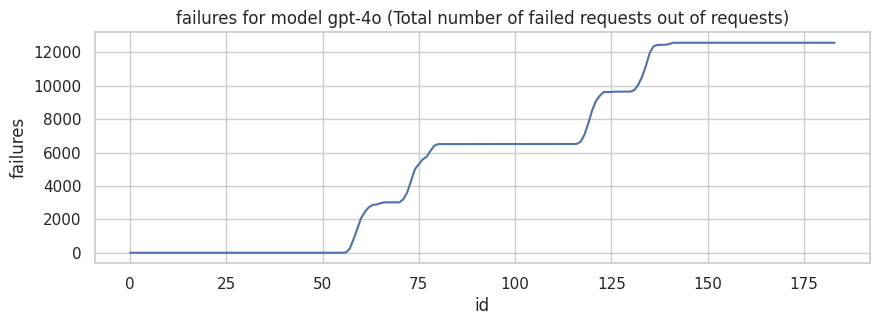

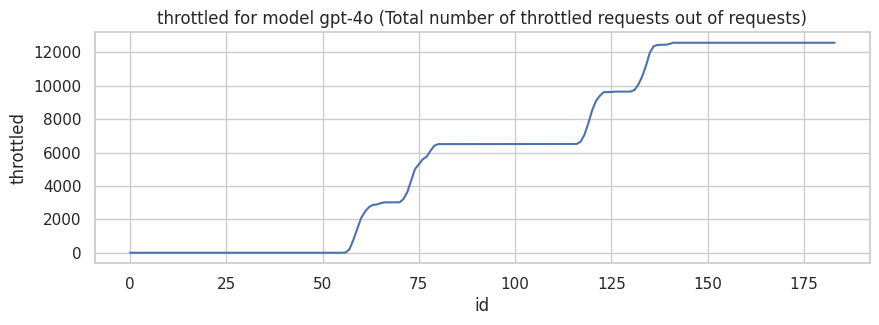

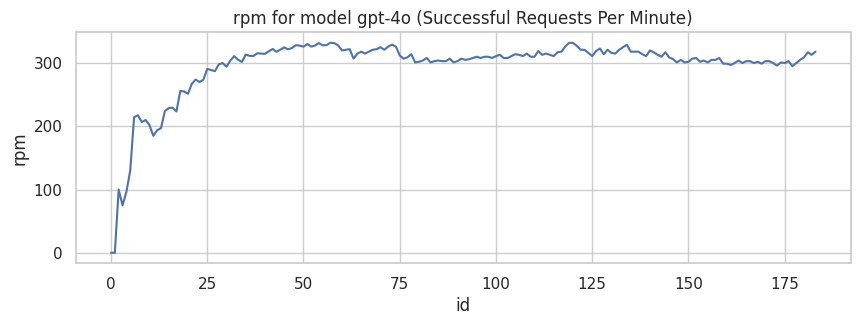

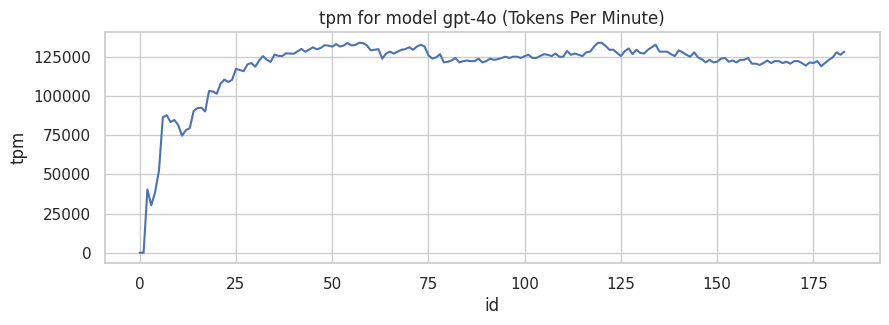

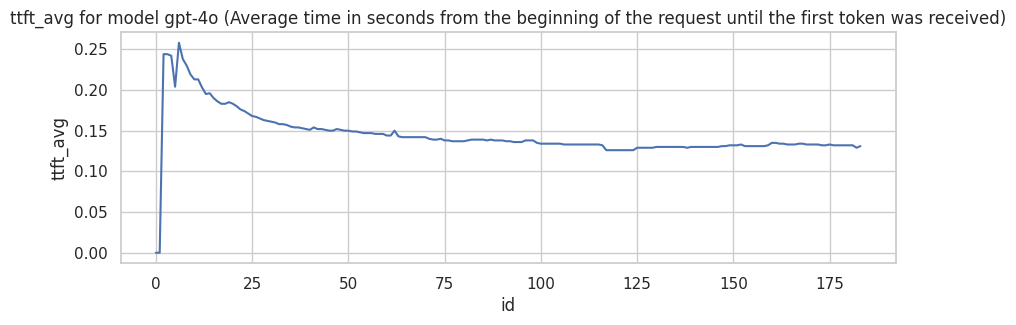

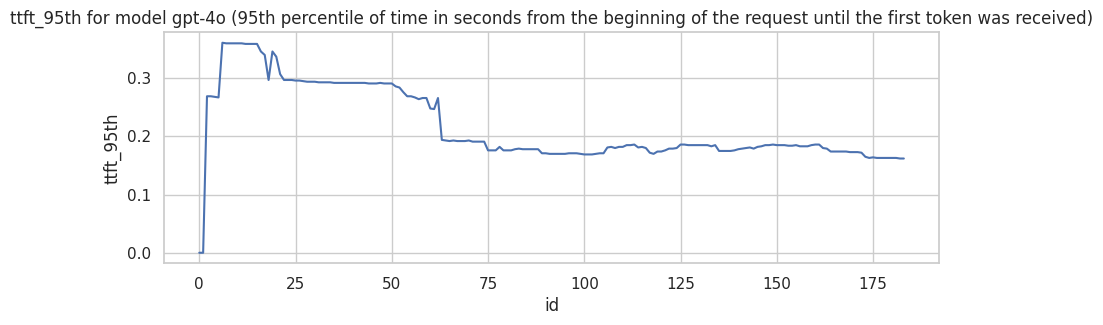

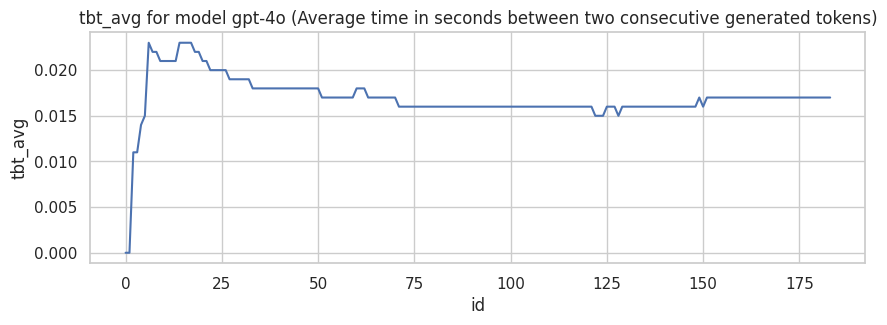

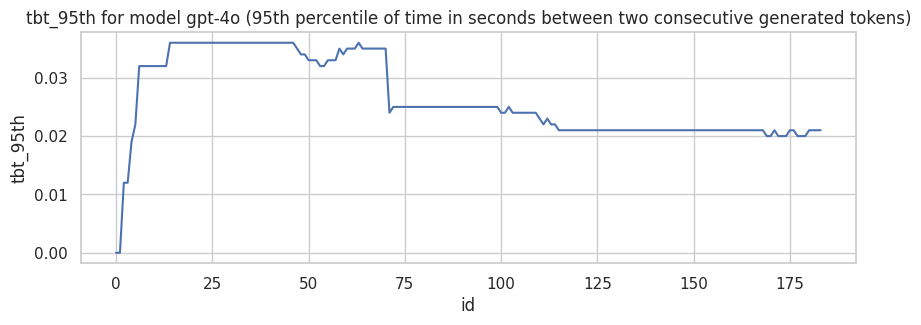

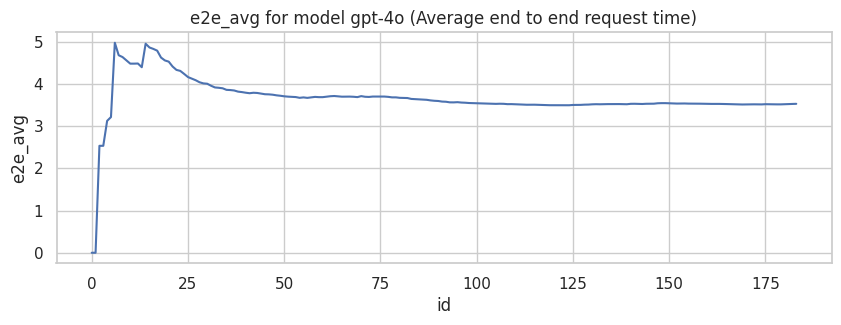

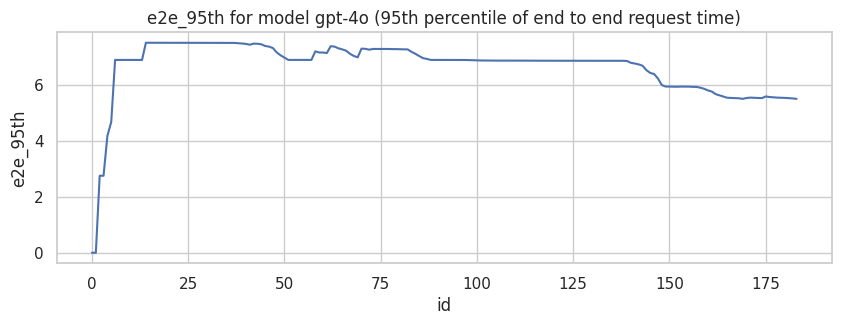

In [29]:
sns.set(style="whitegrid")

for col in cols_to_plot:
    plt.figure(figsize=(10, 3))
    sns.lineplot(data=df1, x='index', y=col)
    plt.title(f'{col} for model {MODEL1} ({metrics_labels[col]})')
    plt.xlabel('id')
    plt.ylabel(col)
    plt.show()

### 4.3 Boxplots using Plotly

In [30]:
for col in cols_to_plot:
    fig = px.box(df1, y=df1[col], title=f'{col} for model {MODEL1} ({metrics_labels[col]})')
    fig.show()
    fig.write_image(os.path.join(HOME, RESULTS_DIR, f"{MODEL1_LABEL}_boxplot_{col}_{local_tz}.jpg"))

### 4.4 Boxplots using Seaborn

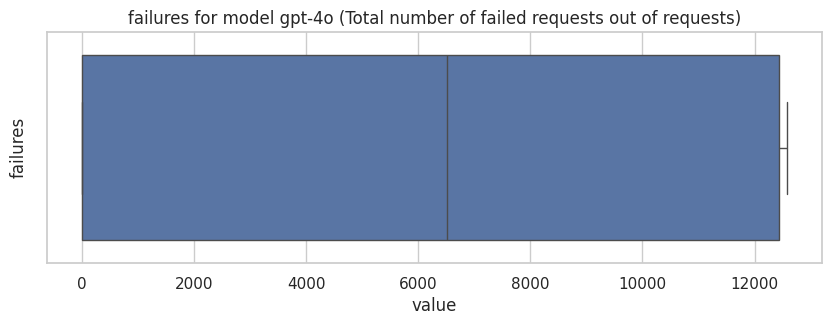

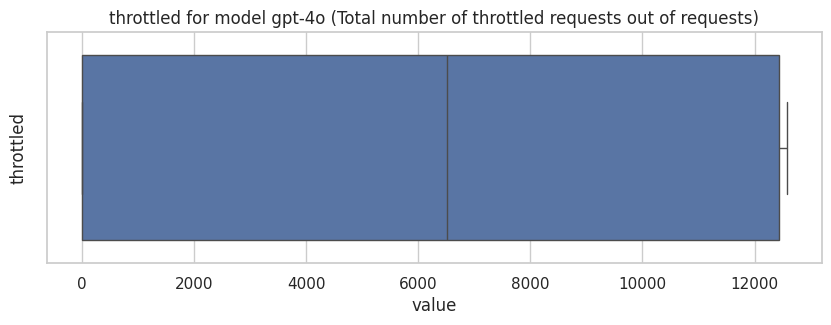

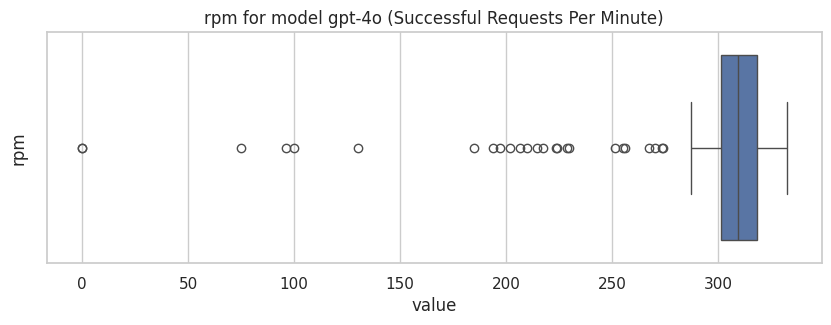

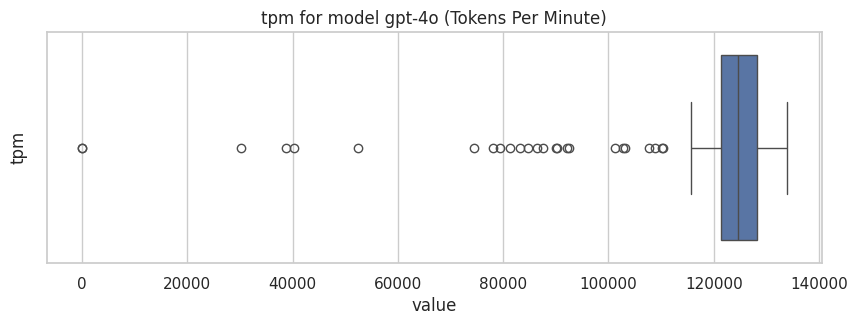

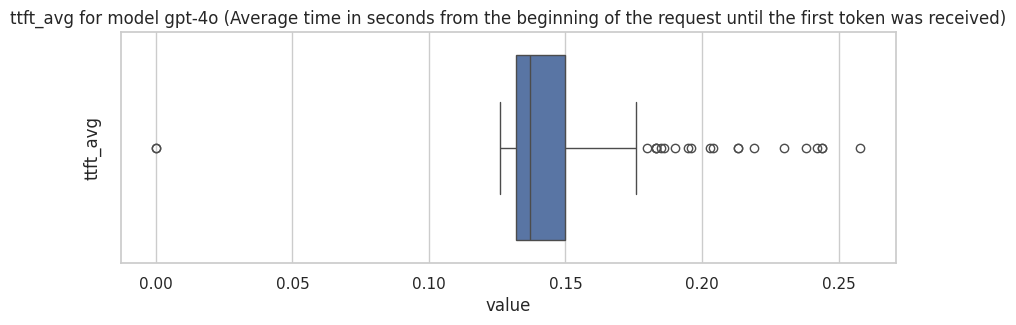

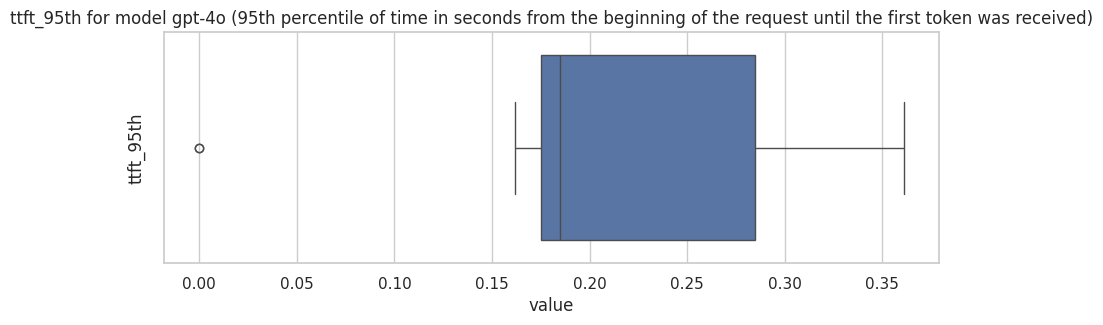

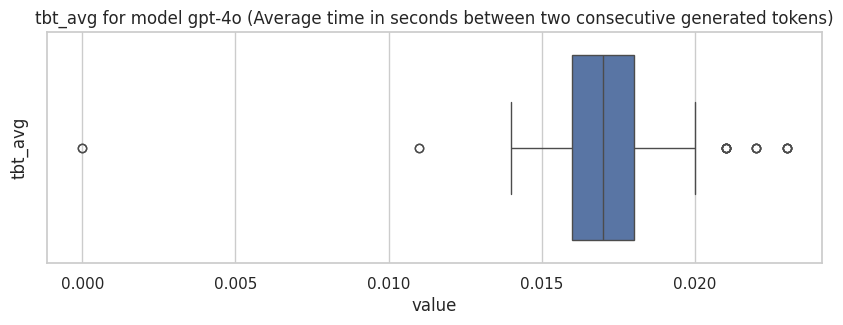

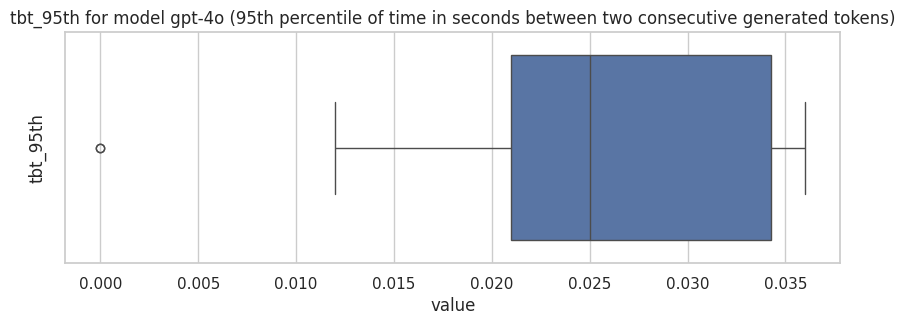

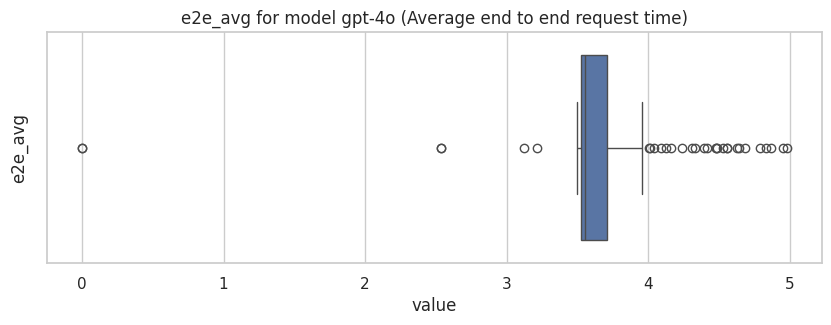

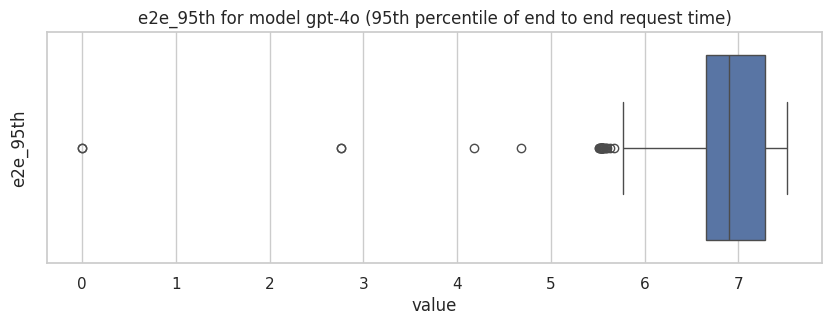

In [31]:
sns.set(style="whitegrid")

for col in cols_to_plot:
    plt.figure(figsize=(10, 3))
    sns.boxplot(x=df1[col])
    plt.title(f'{col} for model {MODEL1} ({metrics_labels[col]})')
    plt.xlabel('value')
    plt.ylabel(col)
    plt.show()

## 5. Second model

### 5.1 Running benchmarks from the second model

In [32]:
os.environ['OPENAI_API_KEY'] = KEY2

In [33]:
print(f"Running benchmarks for model {MODEL2} ...")

Running benchmarks for model gpt-4o-2024-05-13-ptu ...


In [34]:
# With output file generation
OUTPUT_FILE = os.path.join(HOME, RESULTS_DIR, f"benchmarks_{MODEL2_LABEL}_{local_tz}.txt")

command = [
    'python', '-m', 'benchmark.bench', 'load',
    '--deployment', MODEL2,  # Model to use
    #'--rate', '30',  # RPM
    '--duration', '180',  # Duration in seconds (should be > 30 secs)
    '--shape', 'custom',  # Custom request shape
    '--context-tokens', '200',  # Context tokens
    '--max-tokens', '200',  # Max tokens
    '--retry', 'exponential',  # Retry
    '--output-format', 'human',  # Output format
    ENDPOINT2  # Model endpoint to use
]

# Running the benchmarks
start = time.time()
now = datetime.datetime.today()
print(f"{now} Running benchmarks for model {MODEL2}...\n")
result = subprocess.run(command, capture_output=True, text=True)
elapsed = time.time() - start

# Saving the results into a file
with open(OUTPUT_FILE, 'w') as f:
    f.write(result.stdout)

print(f"Benchmark output saved to file {OUTPUT_FILE}\n")
now = datetime.datetime.today()
print("End:", now)
print("Elapsed time: " + time.strftime(
    "%H:%M:%S.{}".format(str(elapsed % 1)[2:])[:15], time.gmtime(elapsed)))

2024-07-11 13:26:15.035236 Running benchmarks for model gpt-4o-2024-05-13-ptu...

Benchmark output saved to file /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/results/results_11Jul2024_152243/benchmarks_gpt-4o PTU Sweden_11Jul2024_152243.txt

End: 2024-07-11 13:29:25.975770
Elapsed time: 00:03:10.829192


In [35]:
# Define the columns to read and their corresponding indices in the file
columns = {
    'timestamp': (0, 2),
    'rpm': 3,
    'processing': 5,
    'completed': 7,
    'failures': 9,
    'throttled': 11,
    'requests': 13,
    'tpm': 15,
    'ttft_avg': 17,
    'ttft_95th': 19,
    'tbt_avg': 21,
    'tbt_95th': 23,
    'e2e_avg': 25,
    'e2e_95th': 27,
    'util_avg': 29,
    'util_95th': 31
}

data = {key: [] for key in columns.keys()}

# Reading file
with open(OUTPUT_FILE, 'r') as file:
    for line in file:
        fields = line.strip().split()
        for key, idx in columns.items():
            if isinstance(idx, tuple):
                value = ' '.join(fields[idx[0]:idx[1]])
            else:
                value = fields[idx]
            data[key].append(value)

df2 = pd.DataFrame(data)
df2 = df2.replace('n/a', 0)
int_columns = ['processing', 'completed', 'failures', 'throttled', 'requests']
float_columns = [
    'rpm', 'tpm', 'ttft_avg', 'ttft_95th', 'tbt_avg', 'tbt_95th', 'e2e_avg',
    'e2e_95th',
]
df2[int_columns] = df2[int_columns].astype(int)
df2[float_columns] = df2[float_columns].astype(float)
df2['model'] = MODEL2

In [36]:
df2.shape

(190, 17)

In [37]:
df2

timestamp    rpm  processing  completed  failures  throttled  \
0    2024-07-11 13:26:17    0.0          20          0         0          0   
1    2024-07-11 13:26:18    0.0          20          0         0          0   
2    2024-07-11 13:26:19   20.0          20          1         0          0   
3    2024-07-11 13:26:20   75.0          20          5         0          0   
4    2024-07-11 13:26:21  216.0          20         18         0          0   
..                   ...    ...         ...        ...       ...        ...   
185  2024-07-11 13:29:22  148.0           7        639         0          0   
186  2024-07-11 13:29:23  151.0           4        642         0          0   
187  2024-07-11 13:29:24  147.0           3        643         0          0   
188  2024-07-11 13:29:25  149.0           1        645         0          0   
189  2024-07-11 13:29:25  146.0           0        646         0          0   

     requests      tpm  ttft_avg  ttft_95th  tbt_avg  tbt_95th  e2e_avg  \
0           0      0.0     0.000      0.000    0.000     0.000    0.000   
1           0      0.0     0.000      0.000    0.000     0.000    0.000   
2           1   8060.0     0.240      0.000    0.013     0.000    2.782   
3           5  30225.0     0.266      0.275    0.016     0.017    3.546   
4          18  87048.0     0.301      0.346    0.020     0.023    4.438   
..        ...      ...       ...        ...      ...       ...      ...   
185       639  59644.0     5.408     19.514    0.015     0.021    5.948   
186       642  60853.0     5.448     19.359    0.015     0.021    5.971   
187       643  59241.0     5.332     18.212    0.015     0.021    5.985   
188       645  60047.0     5.372     18.002    0.015     0.021    6.005   
189       646  58838.0     5.487     18.317    0.015     0.021    6.012   

     e2e_95th util_avg util_95th                  model  
0       0.000        0         0  gpt-4o-2024-05-13-ptu  
1       0.000        0         0  gpt-4o-2024-05-13-ptu  
2       0.000     8.3%         0  gpt-4o-2024-05-13-ptu  
3       3.814     7.5%      9.9%  gpt-4o-2024-05-13-ptu  
4       4.988     5.3%      9.9%  gpt-4o-2024-05-13-ptu  
..        ...      ...       ...                    ...  
185    16.990    99.7%    100.0%  gpt-4o-2024-05-13-ptu  
186    17.154    99.7%    100.0%  gpt-4o-2024-05-13-ptu  
187    17.144    99.7%    100.0%  gpt-4o-2024-05-13-ptu  
188    17.123    99.7%    100.0%  gpt-4o-2024-05-13-ptu  
189    17.112    99.7%    100.0%  gpt-4o-2024-05-13-ptu  

[190 rows x 17 columns]

In [38]:
df2.describe()

rpm  processing   completed  failures  throttled    requests  \
count  190.000000  190.000000  190.000000     190.0      190.0  190.000000   
mean   214.613684   19.400000  380.710526       0.0        0.0  380.710526   
std     78.023236    2.948948  178.458406       0.0        0.0  178.458406   
min      0.000000    0.000000    0.000000       0.0        0.0    0.000000   
25%    151.250000   20.000000  266.750000       0.0        0.0  266.750000   
50%    178.500000   20.000000  403.500000       0.0        0.0  403.500000   
75%    289.500000   20.000000  529.000000       0.0        0.0  529.000000   
max    340.500000   20.000000  646.000000       0.0        0.0  646.000000   

                 tpm    ttft_avg   ttft_95th     tbt_avg    tbt_95th  \
count     190.000000  190.000000  190.000000  190.000000  190.000000   
mean    86489.436842    2.572253   10.348516    0.016011    0.021295   
std     31443.509153    2.141302    8.370101    0.002083    0.003104   
min         0.000000    0.000000    0.000000    0.000000    0.000000   
25%     60953.750000    0.224250    0.340500    0.015000    0.020000   
50%     71935.500000    2.349000   11.185000    0.016000    0.022500   
75%    116668.500000    4.726750   18.747000    0.017000    0.023000   
max    137222.000000    5.487000   23.323000    0.020000    0.023000   

          e2e_avg    e2e_95th  
count  190.000000  190.000000  
mean     4.590489   10.380989  
std      0.947318    4.715180  
min      0.000000    0.000000  
25%      3.749500    4.995000  
50%      4.575000   11.656500  
75%      5.407750   14.645750  
max      6.012000   17.154000

### 5.2 Lineplots using Plotly

In [39]:
df2 = df2.reset_index()

In [40]:
for col in cols_to_plot:
    fig = px.line(
        df2,
        x=df2.index,
        y=df2[col],
        title=f'{col} for model {MODEL2} ({metrics_labels[col]})',
        template="plotly",
    )
    fig.show()
    fig.write_image(os.path.join(HOME, RESULTS_DIR, f"{MODEL2_LABEL}_lineplot_{col}_{local_tz}.jpg"))

### 5.3 Lineplots using Seaborn

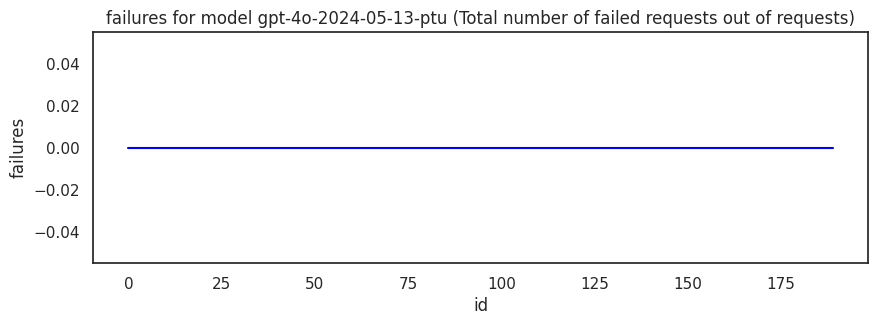

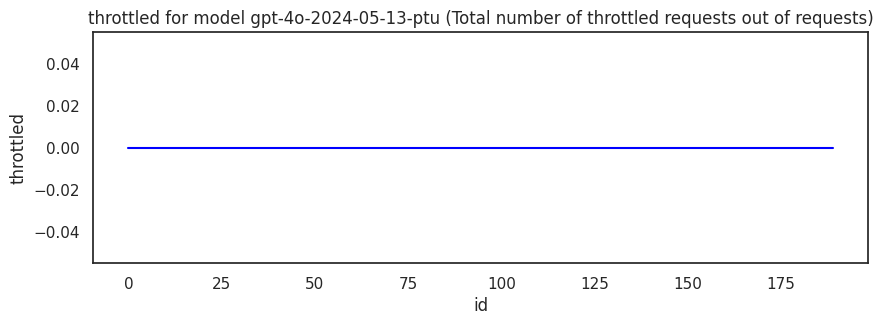

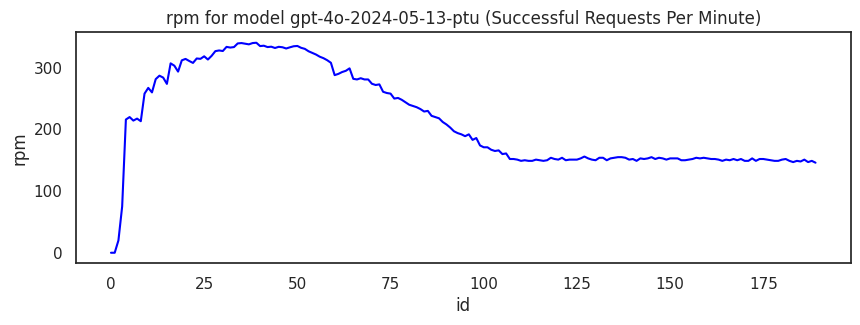

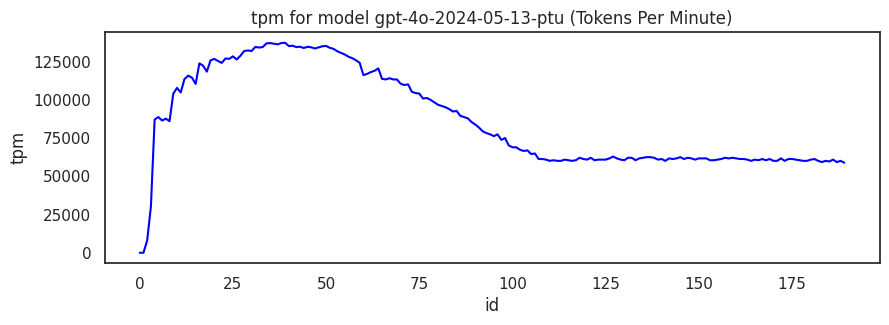

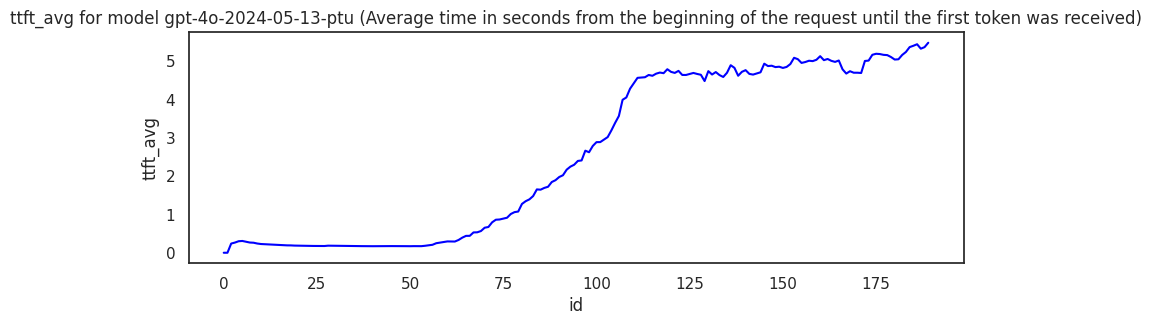

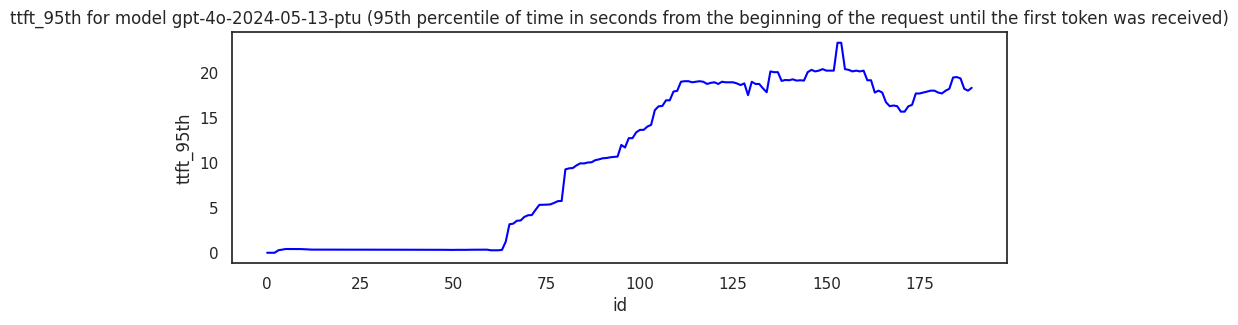

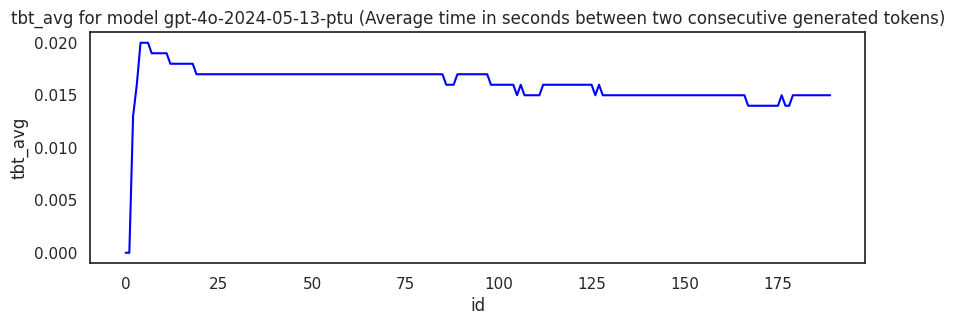

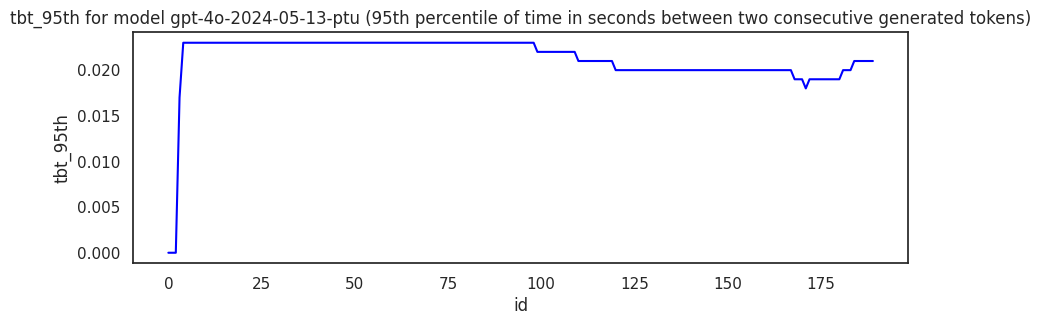

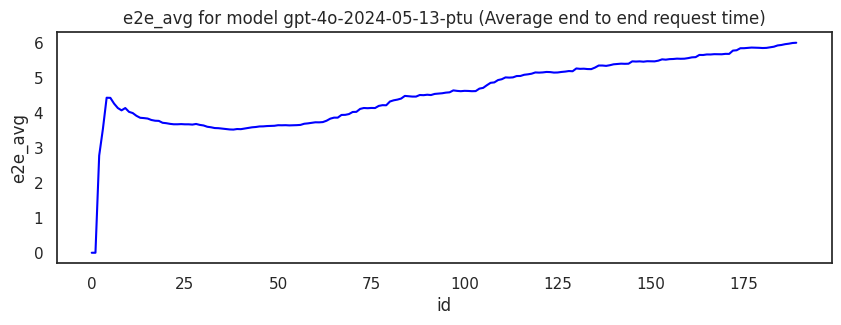

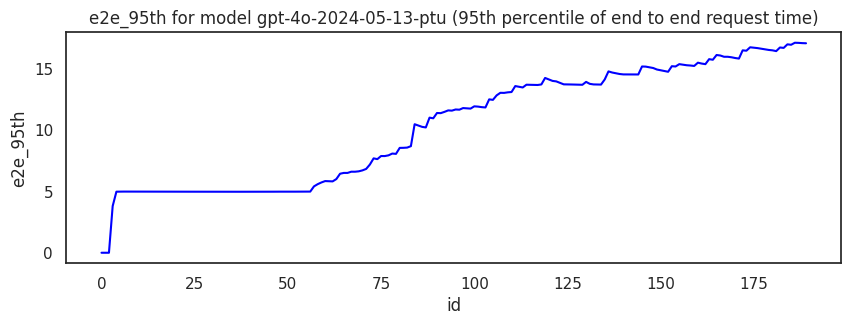

In [41]:
sns.set(style="white")

for col in cols_to_plot:
    plt.figure(figsize=(10, 3))
    sns.lineplot(data=df2, x='index', y=col, color='blue')
    plt.title(f'{col} for model {MODEL2} ({metrics_labels[col]})')
    plt.xlabel('id')
    plt.ylabel(col)
    plt.show()

### 5.4 Boxplots using Plotly

In [42]:
for col in cols_to_plot:
    fig = px.box(df2,
                 y=df2[col],
                 title=f'{col} for model {MODEL2} ({metrics_labels[col]})',
                 template="plotly")
    fig.show()
    fig.write_image(os.path.join(HOME, RESULTS_DIR, f"{MODEL2_LABEL}_boxplot_{col}_{local_tz}.jpg"))

### 5.5 Boxplots using Seaborn

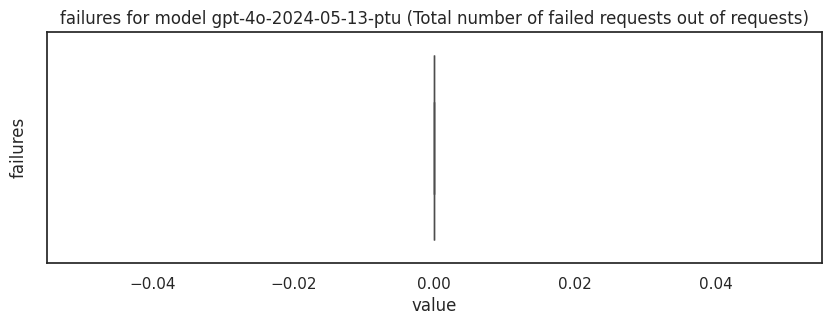

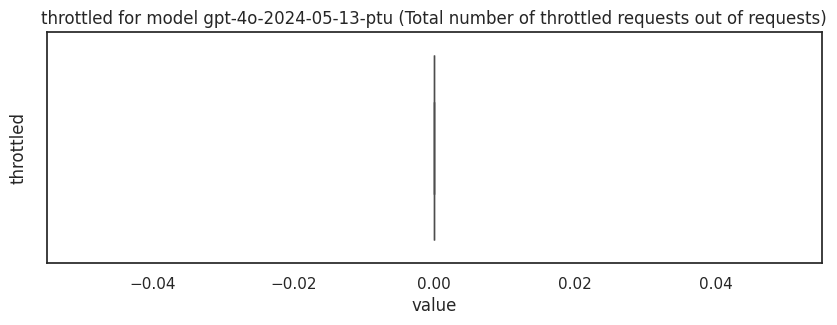

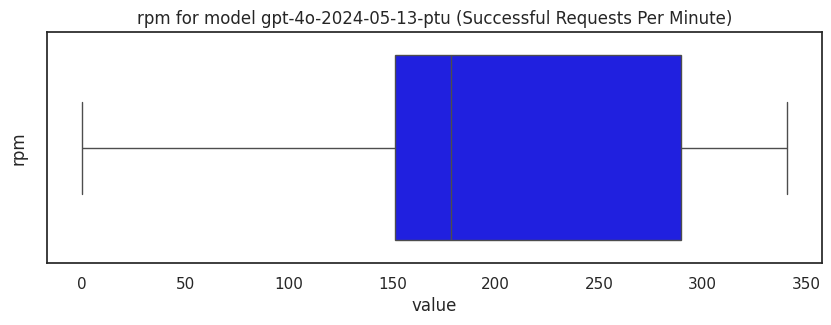

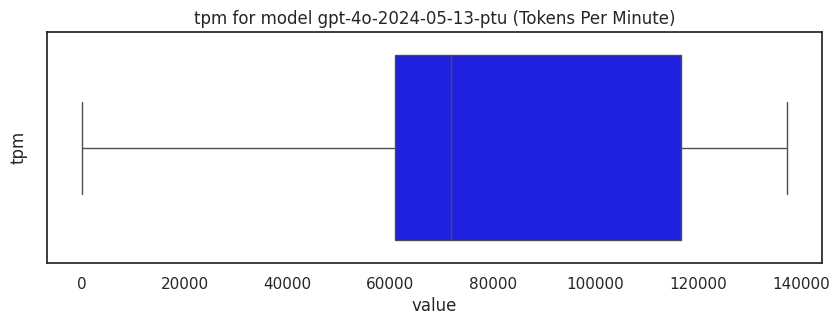

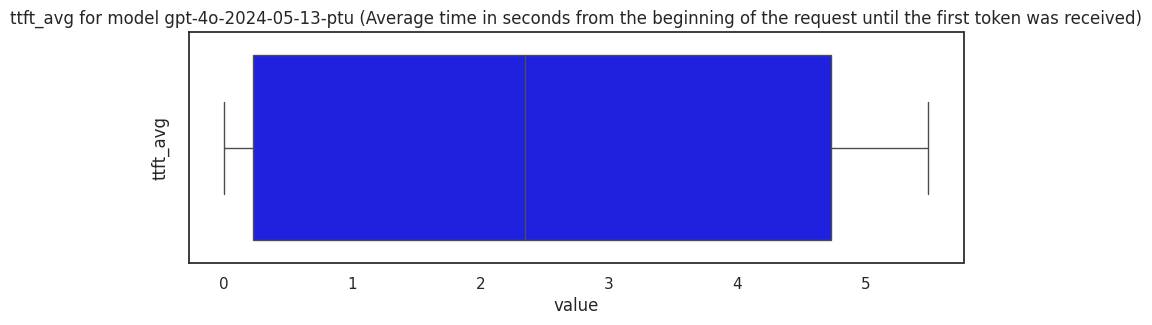

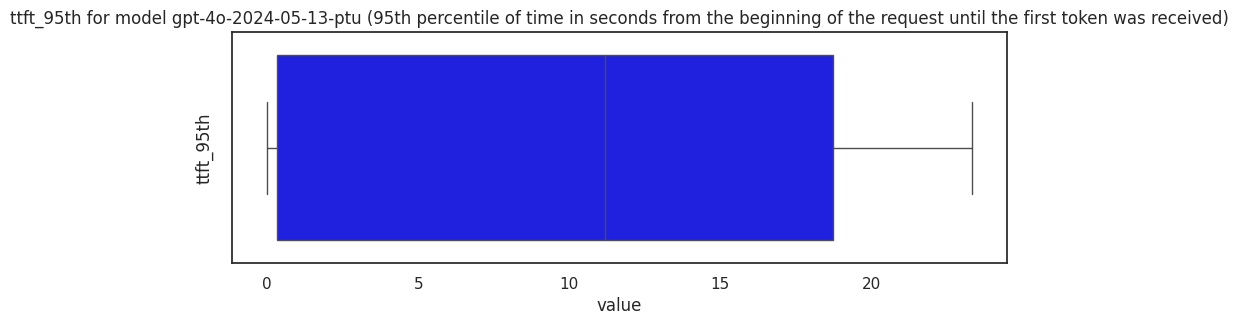

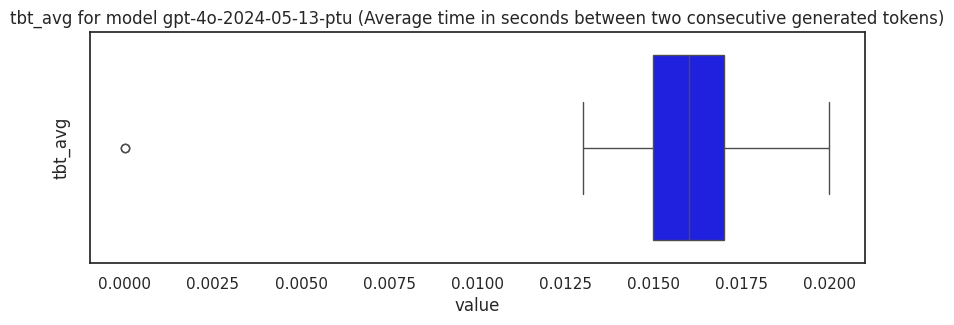

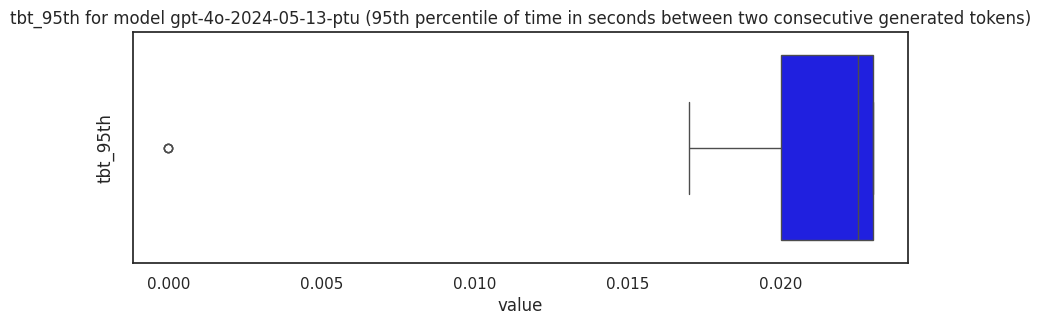

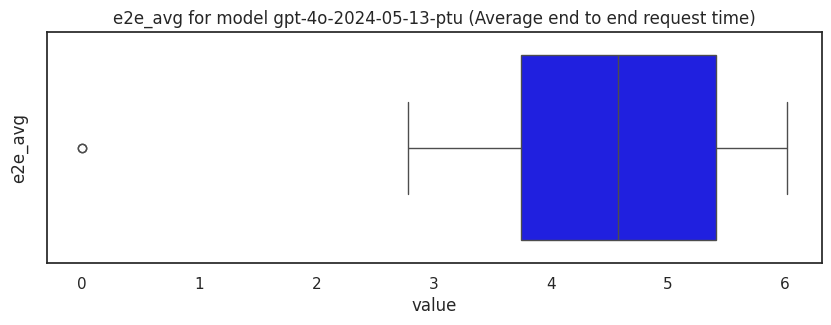

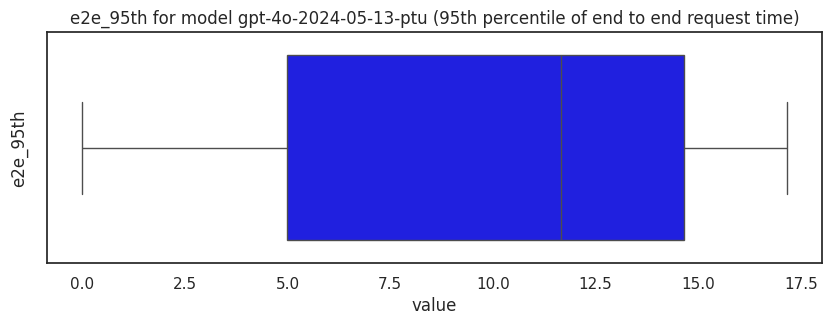

In [43]:
sns.set(style="white")

for col in cols_to_plot:
    plt.figure(figsize=(10, 3))
    sns.boxplot(x=df2[col], color="blue")
    plt.title(f'{col} for model {MODEL2} ({metrics_labels[col]})')
    plt.xlabel('value')
    plt.ylabel(col)
    plt.show()

## 6. Benchmarks comparison results

In [44]:
df1.describe()

index         rpm      failures     throttled            tpm  \
count  184.000000  184.000000    184.000000    184.000000     184.000000   
mean    91.500000  295.566848   5985.038043   5985.038043  119113.391304   
std     53.260367   51.380808   5007.457796   5007.457796   20706.091441   
min      0.000000    0.000000      0.000000      0.000000       0.000000   
25%     45.750000  301.000000      0.000000      0.000000  121303.000000   
50%     91.500000  309.000000   6505.000000   6505.000000  124527.000000   
75%    137.250000  318.000000  12440.500000  12440.500000  128154.000000   
max    183.000000  332.100000  12571.000000  12571.000000  133824.000000   

         ttft_avg   ttft_95th     tbt_avg    tbt_95th     e2e_avg    e2e_95th  \
count  184.000000  184.000000  184.000000  184.000000  184.000000  184.000000   
mean     0.145005    0.216929    0.016957    0.026342    3.663663    6.662348   
std      0.029714    0.065074    0.002598    0.006995    0.524266    1.049410   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.132000    0.175000    0.016000    0.021000    3.521000    6.655500   
50%      0.137000    0.185000    0.017000    0.025000    3.551500    6.897500   
75%      0.150000    0.284500    0.018000    0.034250    3.709500    7.285250   
max      0.258000    0.361000    0.023000    0.036000    4.976000    7.517000   

       util_avg  util_95th  
count     184.0      184.0  
mean        0.0        0.0  
std         0.0        0.0  
min         0.0        0.0  
25%         0.0        0.0  
50%         0.0        0.0  
75%         0.0        0.0  
max         0.0        0.0

In [45]:
df2.describe()

index         rpm  processing   completed  failures  throttled  \
count  190.000000  190.000000  190.000000  190.000000     190.0      190.0   
mean    94.500000  214.613684   19.400000  380.710526       0.0        0.0   
std     54.992424   78.023236    2.948948  178.458406       0.0        0.0   
min      0.000000    0.000000    0.000000    0.000000       0.0        0.0   
25%     47.250000  151.250000   20.000000  266.750000       0.0        0.0   
50%     94.500000  178.500000   20.000000  403.500000       0.0        0.0   
75%    141.750000  289.500000   20.000000  529.000000       0.0        0.0   
max    189.000000  340.500000   20.000000  646.000000       0.0        0.0   

         requests            tpm    ttft_avg   ttft_95th     tbt_avg  \
count  190.000000     190.000000  190.000000  190.000000  190.000000   
mean   380.710526   86489.436842    2.572253   10.348516    0.016011   
std    178.458406   31443.509153    2.141302    8.370101    0.002083   
min      0.000000       0.000000    0.000000    0.000000    0.000000   
25%    266.750000   60953.750000    0.224250    0.340500    0.015000   
50%    403.500000   71935.500000    2.349000   11.185000    0.016000   
75%    529.000000  116668.500000    4.726750   18.747000    0.017000   
max    646.000000  137222.000000    5.487000   23.323000    0.020000   

         tbt_95th     e2e_avg    e2e_95th  
count  190.000000  190.000000  190.000000  
mean     0.021295    4.590489   10.380989  
std      0.003104    0.947318    4.715180  
min      0.000000    0.000000    0.000000  
25%      0.020000    3.749500    4.995000  
50%      0.022500    4.575000   11.656500  
75%      0.023000    5.407750   14.645750  
max      0.023000    6.012000   17.154000

### Using Plotly

In [46]:
for col in cols_to_plot:
    combined_df = pd.concat([df1[[col, 'model']], df2[[col, 'model']]])
    fig = px.box(combined_df,
                 x="model",
                 y=col,
                 color='model',
                 title=f"{col} ({metrics_labels[col]})",
                 color_discrete_map={
                     "f'{MODEL1}'": COLOR1,
                     "f'{MODEL2}'": COLOR2
                 })
    fig.update_xaxes(title_text="Models",
                     ticktext=[f"{MODEL1}", f"{MODEL2}"])
    fig.update_layout(showlegend=False, template="seaborn")
    fig.show()
    fig.write_image(os.path.join(HOME, RESULTS_DIR, f"{MODEL1_LABEL}_{MODEL2_LABEL}_{col}_{local_tz}.jpg"))

### Using Seaborn

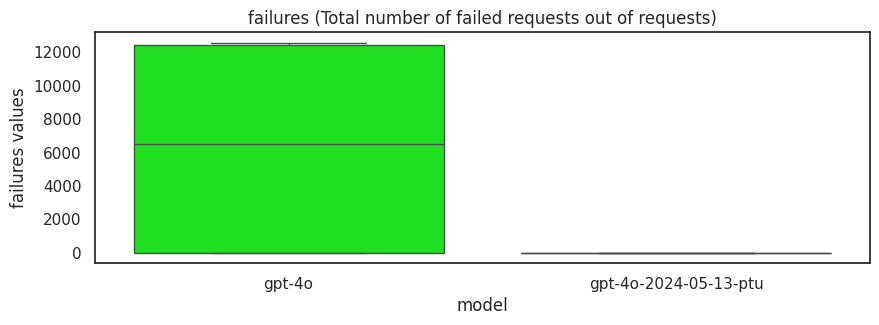

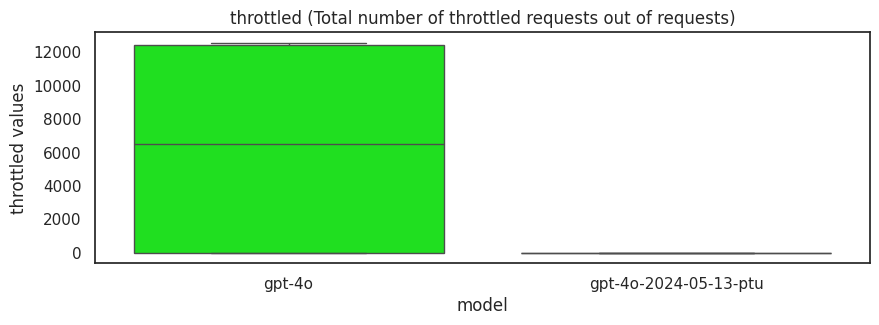

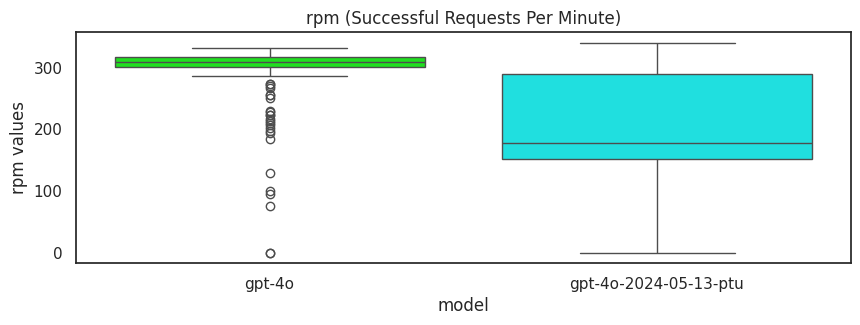

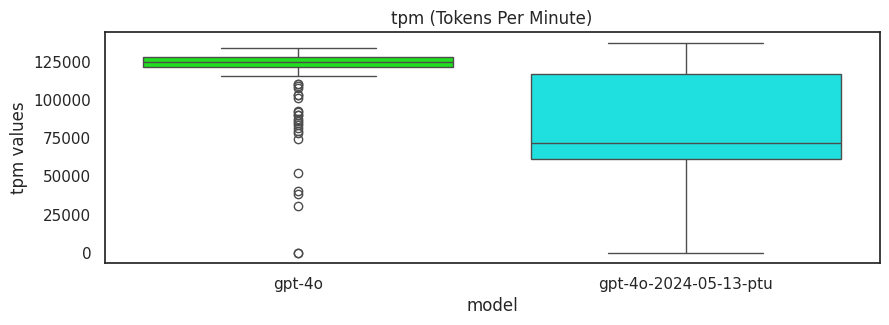

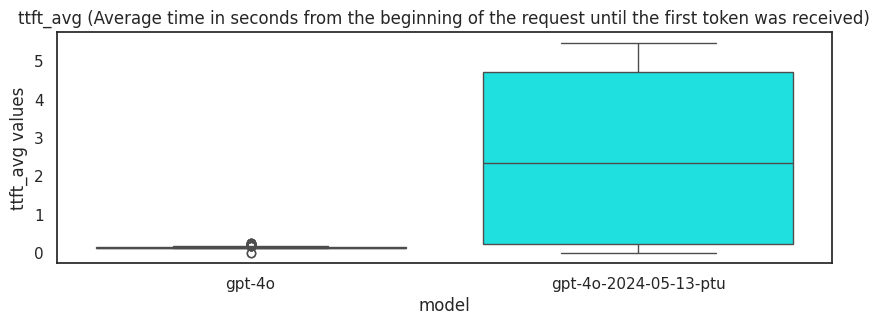

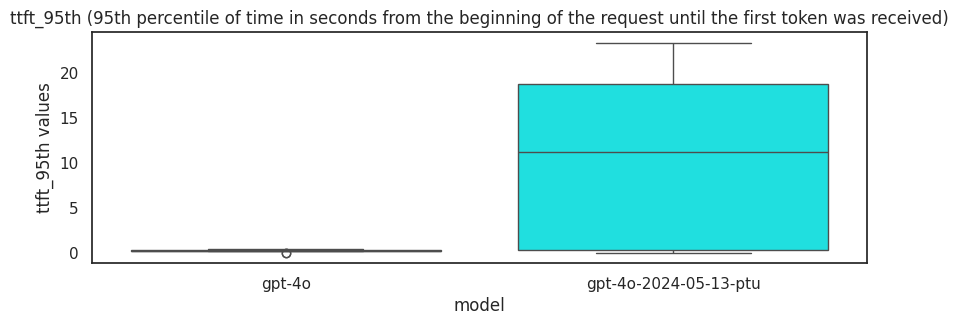

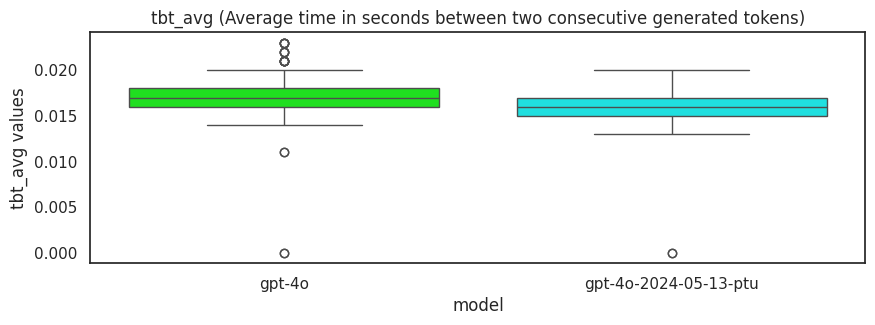

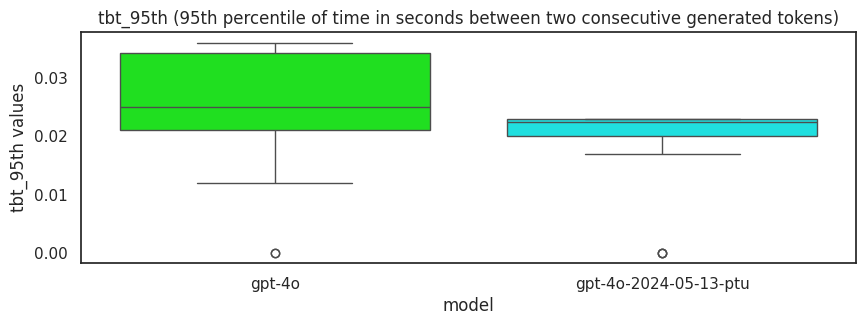

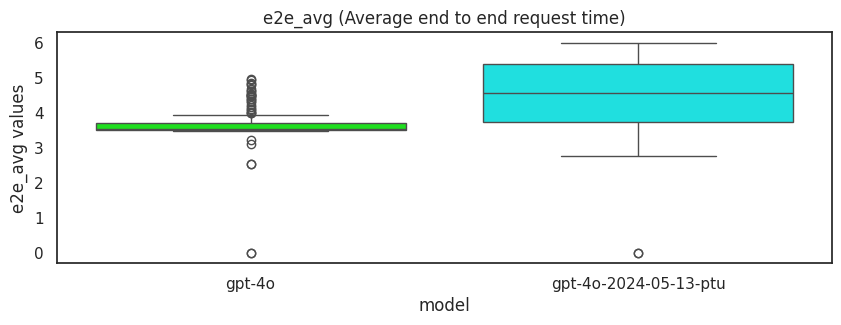

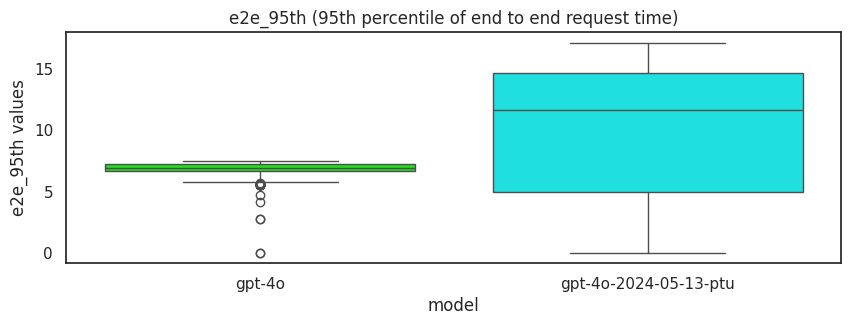

In [47]:
custom_palette = {f"{MODEL1}": COLOR1, f"{MODEL2}": COLOR2}

for col in cols_to_plot:
    combined_df = pd.concat([df1[[col, 'model']], df2[[col, 'model']]])
    plt.figure(figsize=(10, 3))
    sns.boxplot(x='model',
                y=col,
                hue='model',
                data=combined_df,
                palette=custom_palette,
                dodge=False,
                legend=False)
    plt.title(f"{col} ({metrics_labels[col]})")
    plt.ylabel(f"{col} values")
    plt.show()

### Excel exports

In [48]:
df1.to_excel(os.path.join(HOME, RESULTS_DIR, f"benchmarks_{MODEL1_LABEL}_{local_tz}.xlsx"))

In [49]:
df2.to_excel(os.path.join(HOME, RESULTS_DIR, f"benchmarks_{MODEL2_LABEL}_{local_tz}.xlsx"))

In [50]:
all_df = pd.concat([df1, df2], ignore_index=True)

all_df.to_excel(
    os.path.join(HOME, RESULTS_DIR, f"benchmarks_{MODEL1_LABEL}_and_{MODEL2_LABEL}_{local_tz}.xlsx"))

## 07. Use Azure OpenAI to analyse the benchmarks results

In [51]:
# Setting up the AOAI client
client = AzureOpenAI(
        api_key=KEY1,
        api_version="2024-02-01",
        base_url=f"{ENDPOINT1}openai/deployments/{MODEL1}",
)

In [52]:
benchmarks_results = os.path.join(HOME, RESULTS_DIR, f"benchmarks_{MODEL1_LABEL}_and_{MODEL2_LABEL}_{local_tz}.xlsx")
df = pd.read_excel(benchmarks_results)

In [53]:
# Prompt
SYSTEM_MSG = "Analyze the following data. This dataset is a benchmarks about two GenAI models. \
You should provide insights for each model and generate a comparative analysis. Give some details \
in a markdown format:\n\n"

PROMPT = df.to_string(index=False)

In [54]:
# Sending the request
response = client.chat.completions.create(
    model=f"{MODEL2}",
    messages=[
        {"role": "system", "content": SYSTEM_MSG},
        {"role": "user", "content": PROMPT},
    ],
    temperature=0.0,
)

In [55]:
# Print the results
print("\033[1;31;34m")
report = response.choices[0].message.content
print(report)


## Insights for Each Model

### Model: gpt-4o

#### Performance Metrics:
- **RPM (Requests Per Minute):** The RPM starts at 0 and gradually increases, peaking at 330.0 RPM.
- **Processing:** Consistently at 20 throughout the dataset.
- **Completed Requests:** Increases steadily from 0 to 7,060.
- **Failures:** No failures recorded until the last few entries where failures start appearing.
- **Throttled Requests:** No throttled requests until the last few entries.
- **Requests:** Increases steadily, peaking at 7,060.
- **TPM (Transactions Per Minute):** Peaks at 133,824.
- **TTFT (Time to First Transaction):** Average TTFT decreases from 0.244 to 0.133 seconds.
- **TBT (Time to Best Transaction):** Average TBT remains around 0.017 seconds.
- **E2E (End-to-End Time):** Average E2E time decreases from 2.534 to 3.529 seconds.
- **Utilization:** Utilization remains at 0% throughout the dataset.

### Model: gpt-4o-2024-05-13-ptu

#### Performance Metrics:
- **RPM (Requests Per Minute):** St

In [56]:
report_file = os.path.join(
    HOME,
    RESULTS_DIR,
    f"report_{MODEL1_LABEL}_{MODEL2_LABEL}_{local_tz}.md"
)

with open(report_file, "w") as file:
    file.write(report)

print(f"Report saved to {report_file}")

Report saved to /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/results/results_11Jul2024_152243/report_gpt-4o PAYGO Sweden_gpt-4o PTU Sweden_11Jul2024_152243.md


## 8. Saved results

In [57]:
os.chdir(HOME)

In [58]:
excel_link = FileLink(
    path=os.path.join(RESULTS_DIR,
                      f"benchmarks_{MODEL1_LABEL}_and_{MODEL2_LABEL}_{local_tz}.xlsx"
                     )
)
excel_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/results/results_11Jul2024_152243/benchmarks_gpt-4o PAYGO Sweden_and_gpt-4o PTU Sweden_11Jul2024_152243.xlsx

In [59]:
!ls $RESULTS_DIR/*.* -lt

-rwxrwxrwx 1 root root  3557 Jul 11 13:30 'results/results_11Jul2024_152243/report_gpt-4o PAYGO Sweden_gpt-4o PTU Sweden_11Jul2024_152243.md'
-rwxrwxrwx 1 root root 38825 Jul 11 13:29 'results/results_11Jul2024_152243/benchmarks_gpt-4o PAYGO Sweden_and_gpt-4o PTU Sweden_11Jul2024_152243.xlsx'
-rwxrwxrwx 1 root root 22312 Jul 11 13:29 'results/results_11Jul2024_152243/benchmarks_gpt-4o PTU Sweden_11Jul2024_152243.xlsx'
-rwxrwxrwx 1 root root 21101 Jul 11 13:29 'results/results_11Jul2024_152243/benchmarks_gpt-4o PAYGO Sweden_11Jul2024_152243.xlsx'
-rwxrwxrwx 1 root root 23080 Jul 11 13:29 'results/results_11Jul2024_152243/gpt-4o PAYGO Sweden_gpt-4o PTU Sweden_e2e_95th_11Jul2024_152243.jpg'
-rwxrwxrwx 1 root root 21593 Jul 11 13:29 'results/results_11Jul2024_152243/gpt-4o PAYGO Sweden_gpt-4o PTU Sweden_e2e_avg_11Jul2024_152243.jpg'
-rwxrwxrwx 1 root root 27186 Jul 11 13:29 'results/results_11Jul2024_152243/gpt-4o PAYGO Sweden_gpt-4o PTU Sweden_tbt_95th_11Jul2024_152243.jpg'
-rwxrwxrwx 1 r

In [60]:
output_filename = ZIP_DIR + '/archivezip_' + '/'.join(RESULTS_DIR.split('/')[1:])
shutil.make_archive(output_filename, 'zip', RESULTS_DIR)

print(f"Directory {RESULTS_DIR} has been zipped to {output_filename}.zip")

Directory results/results_11Jul2024_152243 has been zipped to zip/archivezip_results_11Jul2024_152243.zip


In [61]:
zipfile_link = FileLink(f"{output_filename}.zip")
zipfile_link

/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow9/code/Users/seretkow/AOAI benchmarks/zip/archivezip_results_11Jul2024_152243.zip

## 9. Post Processing (optional)

In [62]:
# Delete the dir results
#shutil.rmtree(RESULTS_DIR)